# Transfer learning with YAMNet for  sound classification

# train


In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import sys
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import mixed_precision
from IPython.display import Audio
import librosa
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
import tensorflow_io as tfio




2022-08-10 21:51:46.236922: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TF_ENABLE_ONEDNN_OPTS=0

In [3]:
sr = 16000
part = '3'
WEIGHT_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/npzdata/Backing-error/Backing_0_1_data0401_0707_part_'+part+'.npz'
SEED = 42
def plot_time_series(data, sr):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, len(data)/sr, len(data)), data)
    plt.show()


In [4]:
x = np.load(WEIGHT_PATH, mmap_mode='r', allow_pickle=True)
X_train = x['X_train']
y_train = x['y_train']
X_test = x['X_test']
y_test = x['y_test']

In [5]:
classes = np.unique(y_train)
total = len(y_train)
for c in classes:
	n_examples = len(y_train[y_train == c])
	percent = n_examples / total * 100
	print(f'> Class={c} : {n_examples}/{total} {percent}%')

> Class=0 : 114/516 22.093023255813954%
> Class=16 : 402/516 77.90697674418605%


In [6]:
classes = np.unique(y_test)
total = len(y_test)
for c in classes:
	n_examples = len(y_test[y_test == c])
	percent = n_examples / total * 100
	print(f'> Class={c} : {n_examples}/{total} {percent}%')


> Class=0 : 57/257 22.17898832684825%
> Class=16 : 200/257 77.82101167315176%


## change class

In [7]:
for c in classes:
    if c == 0:
        y_train[y_train == c] = 1 
        y_test[y_test == c] = 1 
    elif c == 16:
        y_train[y_train == c] = 0
        y_test[y_test == c] = 0

In [8]:
classes = np.unique(y_train)
total = len(y_train)
for c in classes:
    n_examples = len(y_train[y_train == c])
    percent = n_examples / total * 100
    print(f'> Class={c} : {n_examples}/{total} {percent}%')


> Class=0 : 402/516 77.90697674418605%
> Class=1 : 114/516 22.093023255813954%


In [9]:
classes = np.unique(y_test)
total = len(y_test)
for c in classes:
    n_examples = len(y_test[y_test == c])
    percent = n_examples / total * 100
    print(f'> Class={c} : {n_examples}/{total} {percent}%')


> Class=0 : 200/257 77.82101167315176%
> Class=1 : 57/257 22.17898832684825%


## data augmentation

In [10]:
# minority_data = X_train[y_train == 1]
# minority_label = y_train[y_train == 1]
minority_data = X_train
minority_label = y_train


In [11]:
minority_data.shape


(516, 32000)

In [12]:
minority_label.shape


(516,)

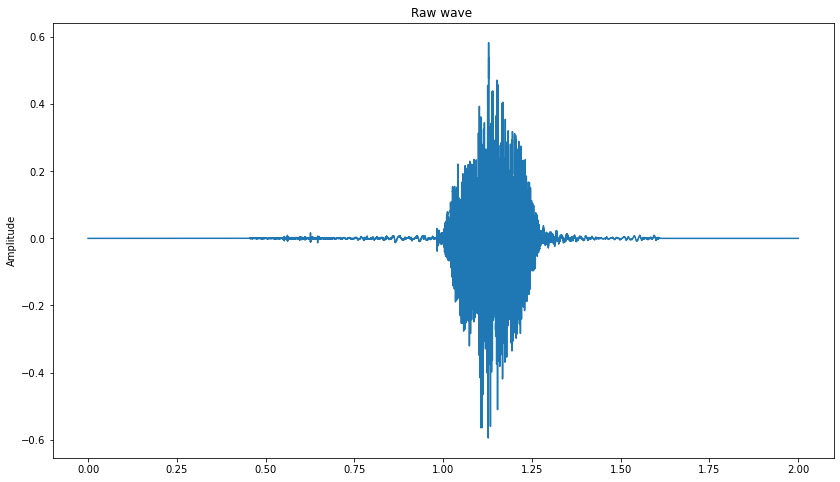

In [13]:
plot_time_series(minority_data[0], sr)
Audio(minority_data[0], rate=sr)

In [14]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment1 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
augment2 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    TimeStretch(min_rate=0.8, max_rate=1.25, p=1)
    # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

augment3 = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)
    # TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
    PitchShift(min_semitones=-4, max_semitones=4, p=1),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=1)
])

augment4 = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)
])

# Generate 2 seconds of dummy audio for the sake of example
# samples = np.random.uniform(
#     low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# Augment/transform/perturb the audio data
augmented_sample1 = augment1(samples=minority_data, sample_rate=sr)
augmented_sample2 = augment2(samples=minority_data, sample_rate=sr)
augmented_sample3 = augment3(samples=minority_data, sample_rate=sr)
augmented_sample4 = augment4(samples=minority_data, sample_rate=sr)


In [15]:
print(f"augmented_sample1.shape: {augmented_sample1.shape}")
print(f"augmented_sample2.shape: {augmented_sample2.shape}")
print(f"augmented_sample3.shape: {augmented_sample3.shape}")
print(f"augmented_sample4.shape: {augmented_sample4.shape}")


augmented_sample1.shape: (516, 32000)
augmented_sample2.shape: (516, 32000)
augmented_sample3.shape: (516, 32000)
augmented_sample4.shape: (516, 32000)


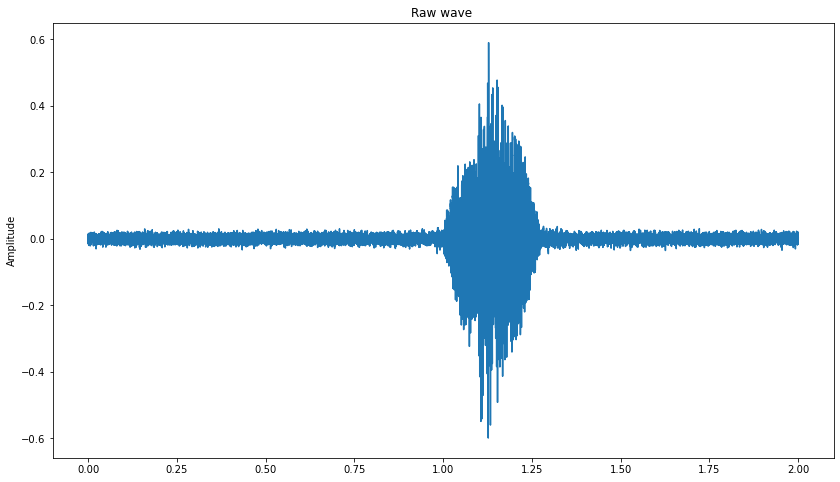

In [16]:
plot_time_series(augmented_sample1[0], sr)
Audio(augmented_sample1[0], rate=sr)

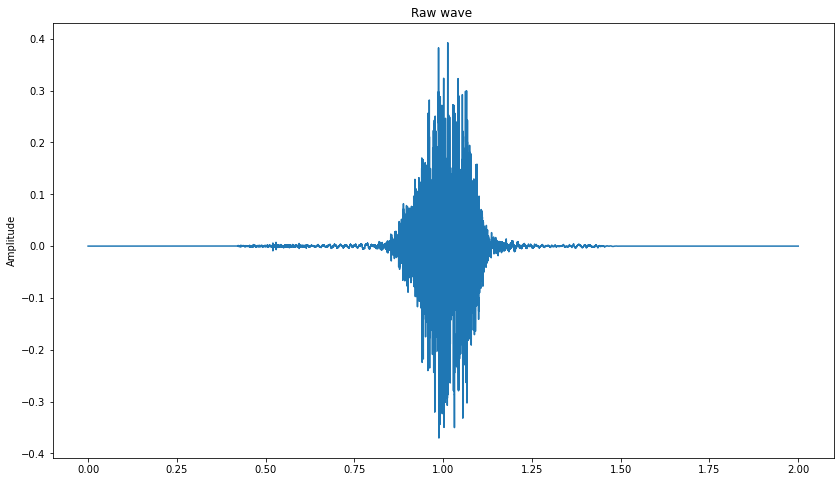

In [17]:
plot_time_series(augmented_sample2[0], sr)
Audio(augmented_sample2[0], rate=sr)


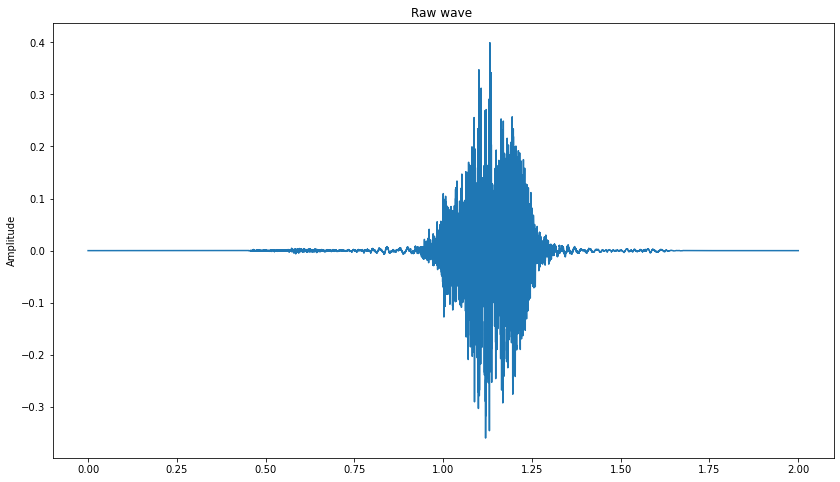

In [18]:
plot_time_series(augmented_sample3[0], sr)
Audio(augmented_sample3[0], rate=sr)

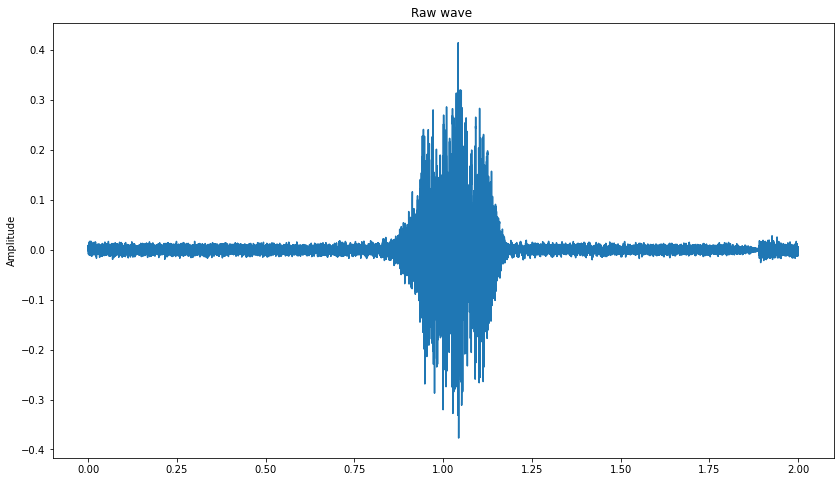

In [19]:
plot_time_series(augmented_sample4[0], sr)
Audio(augmented_sample4[0], rate=sr)

In [20]:
X_train = np.concatenate(
    [X_train, augmented_sample1, augmented_sample2, augmented_sample3, augmented_sample4], axis=0)
y_train = np.concatenate(
    [y_train, minority_label, minority_label, minority_label, minority_label], axis=0)
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")



X_train.shape: (2580, 32000)
y_train.shape: (2580,)


## Random train

In [21]:
order = np.arange(len(y_train))
np.random.seed(SEED)
np.random.shuffle(order)
X_train = X_train[order]
y_train = y_train[order]
X_train.shape


(2580, 32000)

## About YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, you will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. (This is similar to [transfer learning for image classification with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for more information.)

First, you will test the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the `load` function.

Note: to read the documentation of the model, use the model URL in your browser.

In [22]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


2022-08-10 21:52:06.323698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 21:52:06.327061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 21:52:06.327151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 21:52:06.327411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [24]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
          tf.repeat(label, num_embeddings))


# extract embedding
train_ds = train_ds.map(extract_embedding).unbatch()
print(train_ds.element_spec)
test_ds = test_ds.map(extract_embedding).unbatch()
print(train_ds.element_spec)


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


## model

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import tensorflow as tf
import datetime
import tempfile


In [26]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

 

## Define the model and metrics

In [27]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]


def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    inputs = keras.layers.Input(
        shape=(1024), dtype=tf.float32, name='input_embedding')
    x = keras.layers.Dense(512, activation='relu')(inputs)
    outputs = keras.layers.Dense(
        1, activation='sigmoid', bias_initializer=output_bias)(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS)
    return model


### Baseline model

In [28]:
EPOCHS = 50
BATCH_SIZE = 32
SAVE_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/'
model_name = 'YAMNET_model'
output_bias = None
dataset = 'Backing-baseline'
NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+part+'_' + \
    datetime.datetime.now().strftime("%m%d_%H%M")
log_dir = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/logs/' + NAME

In [29]:
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_recall', mode='max',
                   verbose=2, patience=10, restore_best_weights=True)
model = make_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_embedding (InputLayer  [(None, 1024)]           0         
 )                                                               
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________


In [31]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)


In [32]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        es
    ],
    validation_data=test_ds)


Epoch 1/50
323/323 [==============================] - 19s 52ms/step - loss: 0.5294 - tp: 144.0000 - fp: 150.0000 - tn: 7890.0000 - fn: 2136.0000 - accuracy: 0.7785 - precision: 0.4898 - recall: 0.0632 - auc: 0.6118 - prc: 0.3132 - val_loss: 0.5211 - val_tp: 3.0000 - val_fp: 7.0000 - val_tn: 793.0000 - val_fn: 225.0000 - val_accuracy: 0.7743 - val_precision: 0.3000 - val_recall: 0.0132 - val_auc: 0.6080 - val_prc: 0.3105
Epoch 2/50
323/323 [==============================] - 1s 3ms/step - loss: 0.4937 - tp: 224.0000 - fp: 145.0000 - tn: 7895.0000 - fn: 2056.0000 - accuracy: 0.7867 - precision: 0.6070 - recall: 0.0982 - auc: 0.6722 - prc: 0.3851 - val_loss: 0.5443 - val_tp: 3.0000 - val_fp: 2.0000 - val_tn: 798.0000 - val_fn: 225.0000 - val_accuracy: 0.7792 - val_precision: 0.6000 - val_recall: 0.0132 - val_auc: 0.5848 - val_prc: 0.2846
Epoch 3/50
323/323 [==============================] - 1s 3ms/step - loss: 0.4800 - tp: 295.0000 - fp: 176.0000 - tn: 7864.0000 - fn: 1985.0000 - accuracy:

### Check training history

In [33]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

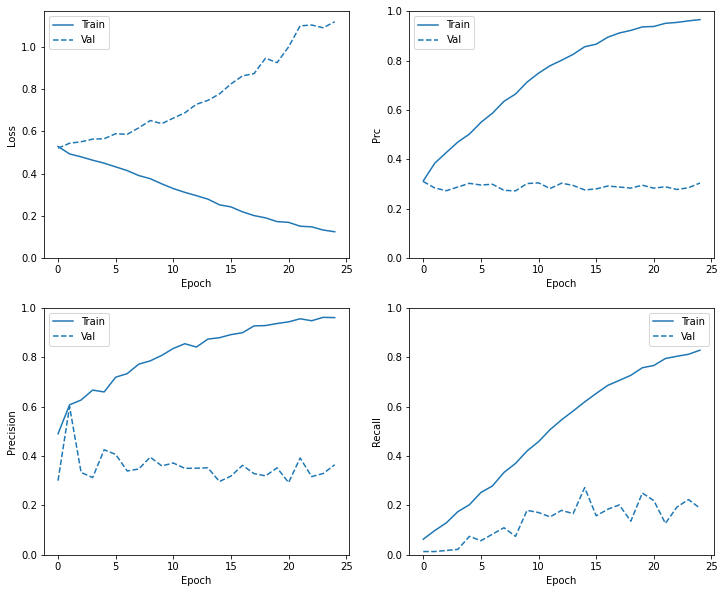

In [34]:
plot_metrics(baseline_history)

### Evaluate metrics


In [35]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [36]:
y_test_pred = []
for x in range(X_test.shape[0]):
    scores, embeddings, spectrogram = yamnet_model(X_test[x])
    result = model(embeddings).numpy()
    result = tf.reduce_mean(result, 0)
    if(result > 0.5):
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)
y_test_pred = np.array(y_test_pred)


2022-08-10 21:52:52.772674: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-10 21:52:52.884818: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-10 21:52:52.885613: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-10 21:52:52.885627: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-10 21:52:52.886252: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-10 21:52:52.886273: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [37]:
def metric(y_true, y_pred):
    TP = tf.reduce_sum(y_true*tf.round(y_pred))
    TN = tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP = tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN = tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision = TP/(TP+FP)
    recall=TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    m = keras.metrics.AUC()
    m.update_state(y_true, y_pred)
    auc = m.result().numpy()
    m = keras.metrics.AUC(curve='PR')
    m.update_state(y_true, y_pred)
    prc = m.result().numpy()
    return TP, TN, FP, FN, precision, recall, accuracy, auc, prc
TP, TN, FP, FN, precision, recall, accuracy, auc, prc = metric(y_test, y_test_pred)
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"auc: {auc}")
print(f"prc: {prc}")
print("")
print(f"Legitimate Transactions Detected (True Negatives): {TN}")
print(f"Legitimate Transactions Incorrectly Detected (False Positives): {FP}")
print(f"Fraudulent Transactions Missed (False Negatives): {FN}")
print(f"Fraudulent Transactions Detected (True Positives): {TP}")


accuracy: 0.7509727626459144
precision: 0.3157894736842105
recall: 0.10526315789473684
auc: 0.5201315879821777
prc: 0.24385464191436768

Legitimate Transactions Detected (True Negatives): 187
Legitimate Transactions Incorrectly Detected (False Positives): 13
Fraudulent Transactions Missed (False Negatives): 51
Fraudulent Transactions Detected (True Positives): 6


In [38]:
# baseline_results = model.evaluate(test_ds,
#                                   batch_size=BATCH_SIZE, verbose=0)

# for name, value in zip(model.metrics_names, baseline_results):
#   print(name, ': ', value)
# print()

# # plot_cm(y_test, tf.squeeze(test_predictions_baseline))


In [39]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


In [40]:
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
baseline_model = tf.keras.Model(input_segment, serving_outputs)

baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)


In [41]:
tmpStr = str(np.round(precision.numpy(), 2)) + \
    '-' + str(np.round(recall.numpy(), 2))
model_save_path = SAVE_PATH + NAME + tmpStr
baseline_model.save(model_save_path)


INFO:tensorflow:Assets written to: /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/YAMNET_model_Backing-baseline_bs32_data_part3_0810_21520.32-0.11/assets


INFO:tensorflow:Assets written to: /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/YAMNET_model_Backing-baseline_bs32_data_part3_0810_21520.32-0.11/assets


# class_weight

In [42]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 2580
    Positive: 570 (22.09% of total)



In [43]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.64
Weight for class 1: 2.26


In [44]:
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)


In [45]:
EPOCHS = 50
BATCH_SIZE = 32
SAVE_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/'
model_name = 'YAMNET_model'
dataset = 'Backing-weighted'
NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+part+'_' + \
    datetime.datetime.now().strftime("%m%d_%H%M")

log_dir = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/logs/' + NAME


In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_recall', mode='max',
                   verbose=2, patience=10, restore_best_weights=True)



In [47]:
model = make_model(output_bias)
model.load_weights(initial_weights)
model.summary()
weighted_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        es
    ],
    validation_data=test_ds)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_embedding (InputLayer  [(None, 1024)]           0         
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
323/323 [==============================] - 2s 4ms/step - loss: 0.5379 - tp: 182.0000 - fp: 259.0000 - tn: 8581.0000 - fn: 2326.0000 - accuracy: 0.7722 - precision: 0.4127 - recall: 0.0726 - auc: 0.6072 - prc: 0.3059 - val_loss: 0.5192 - val

### Check training history

In [48]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

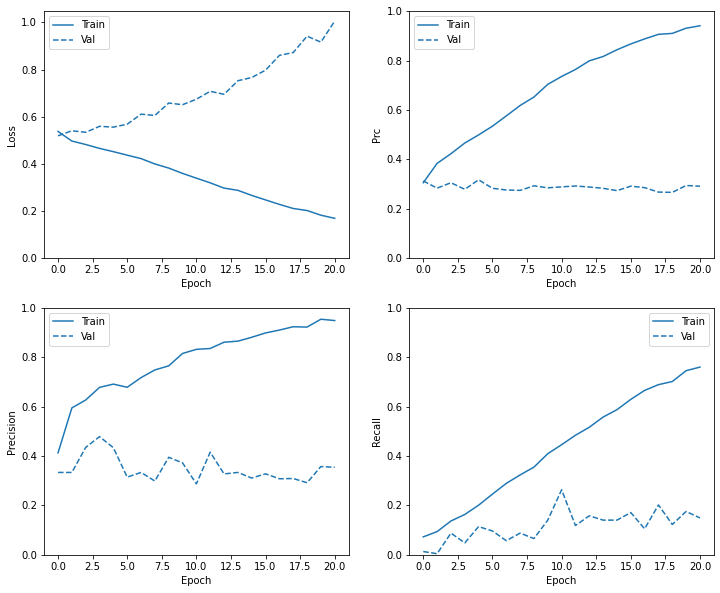

In [49]:
plot_metrics(weighted_history)


In [50]:
y_test_pred = []
for x in range(X_test.shape[0]):
    scores, embeddings, spectrogram = yamnet_model(X_test[x])
    result = model(embeddings).numpy()
    result = tf.reduce_mean(result, 0)
    if(result > 0.5):
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)
y_test_pred = np.array(y_test_pred)


In [51]:
def metric(y_true, y_pred):
    TP = tf.reduce_sum(y_true*tf.round(y_pred))
    TN = tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP = tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN = tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision = TP/(TP+FP)
    recall=TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    m = keras.metrics.AUC()
    m.update_state(y_true, y_pred)
    auc = m.result().numpy()
    m = keras.metrics.AUC(curve='PR')
    m.update_state(y_true, y_pred)
    prc = m.result().numpy()
    return TP, TN, FP, FN, precision, recall, accuracy, auc, prc
TP, TN, FP, FN, precision, recall, accuracy, auc, prc = metric(y_test, y_test_pred)
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"auc: {auc}")
print(f"prc: {prc}")
print("")
print(f"Legitimate Transactions Detected (True Negatives): {TN}")
print(f"Legitimate Transactions Incorrectly Detected (False Positives): {FP}")
print(f"Fraudulent Transactions Missed (False Negatives): {FN}")
print(f"Fraudulent Transactions Detected (True Positives): {TP}")


accuracy: 0.7704280155642024
precision: 0.4444444444444444
recall: 0.14035087719298245
auc: 0.5451753735542297
prc: 0.27983707189559937

Legitimate Transactions Detected (True Negatives): 190
Legitimate Transactions Incorrectly Detected (False Positives): 10
Fraudulent Transactions Missed (False Negatives): 49
Fraudulent Transactions Detected (True Positives): 8


In [52]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


In [53]:
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
weighted_model = tf.keras.Model(input_segment, serving_outputs)

weighted_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)


In [54]:
tmpStr = str(np.round(precision.numpy(), 2)) + \
    '-' + str(np.round(recall.numpy(), 2))
model_save_path = SAVE_PATH + NAME + tmpStr
weighted_model.save(model_save_path)


INFO:tensorflow:Assets written to: /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/YAMNET_model_Backing-weighted_bs32_data_part3_0810_21520.44-0.14/assets


INFO:tensorflow:Assets written to: /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/YAMNET_model_Backing-weighted_bs32_data_part3_0810_21520.44-0.14/assets


## Oversampling

In [55]:
bool_train_labels = y_train != 0


In [56]:
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]


In [57]:
pos_features.shape


(570, 32000)

In [58]:
neg_features.shape


(2010, 32000)

In [59]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape


(2010, 32000)

In [60]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape


(4020, 32000)

In [61]:
BUFFER_SIZE = 100000


def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))  # .cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds


pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


In [62]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())


Features:
 [-6.4704733e-07 -7.4917290e-07 -1.0209939e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]

Label:  1


In [63]:
resampled_ds = tf.data.Dataset.sample_from_datasets(
    [pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.map(extract_embedding).unbatch()
print(resampled_ds.element_spec)
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [64]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())


0.625


In [65]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch


126.0

In [66]:
EPOCHS = 50
BATCH_SIZE = 32
SAVE_PATH = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/'
model_name = 'YAMNET_model'
dataset = 'Backing-oversampling'
NAME = model_name+'_'+dataset+'_bs'+str(BATCH_SIZE)+'_data_' + 'part'+part+'_' + \
    datetime.datetime.now().strftime("%m%d_%H%M")

log_dir = '/D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/logs/' + NAME


In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_recall', mode='max',
                   verbose=2, patience=10, restore_best_weights=True)


In [68]:
model = make_model()
model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = model.layers[-1]
output_layer.bias.assign([0])

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache()
test_ds = test_ds.map(extract_embedding).unbatch()
print(train_ds.element_spec)

test_ds = test_ds.batch(BATCH_SIZE).prefetch(2)
model.summary()




(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_embedding (InputLayer  [(None, 1024)]           0         
 )                                                               
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________


In [69]:
resampled_history = model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[
        TensorBoard(log_dir=log_dir),
        es
    ],
    validation_data=test_ds)


Epoch 1/50
126/126 [==============================] - 9s 67ms/step - loss: 0.7198 - tp: 1086.0000 - fp: 869.0000 - tn: 1983.0000 - fn: 1122.0000 - accuracy: 0.6065 - precision: 0.5555 - recall: 0.4918 - auc: 0.6441 - prc: 0.5474 - val_loss: 0.7104 - val_tp: 135.0000 - val_fp: 376.0000 - val_tn: 424.0000 - val_fn: 93.0000 - val_accuracy: 0.5438 - val_precision: 0.2642 - val_recall: 0.5921 - val_auc: 0.5962 - val_prc: 0.3276
Epoch 2/50
126/126 [==============================] - 8s 63ms/step - loss: 0.6759 - tp: 1328.0000 - fp: 890.0000 - tn: 1050.0000 - fn: 764.0000 - accuracy: 0.5898 - precision: 0.5987 - recall: 0.6348 - auc: 0.6245 - prc: 0.6246 - val_loss: 0.7238 - val_tp: 146.0000 - val_fp: 355.0000 - val_tn: 445.0000 - val_fn: 82.0000 - val_accuracy: 0.5749 - val_precision: 0.2914 - val_recall: 0.6404 - val_auc: 0.6196 - val_prc: 0.2916
Epoch 3/50
126/126 [==============================] - 8s 64ms/step - loss: 0.6636 - tp: 943.0000 - fp: 605.0000 - tn: 1587.0000 - fn: 897.0000 - ac

### Check training history

In [70]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

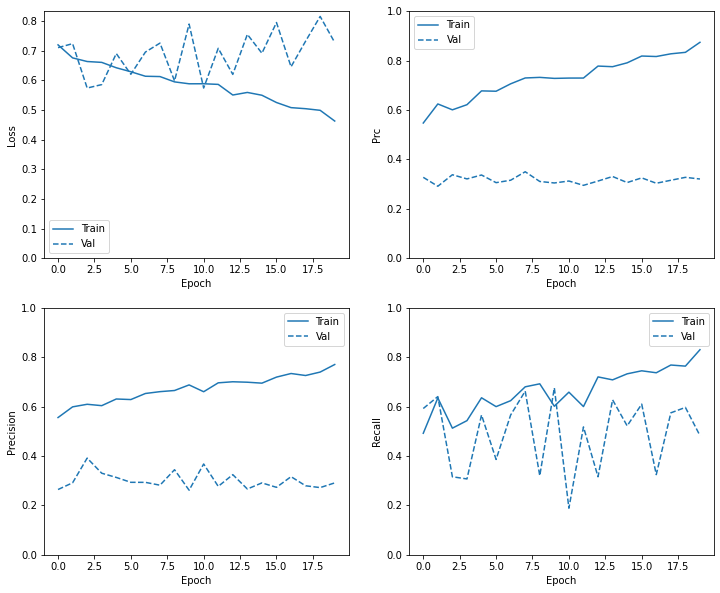

In [71]:
plot_metrics(resampled_history)


In [72]:
y_test_pred = []
for x in range(X_test.shape[0]):
    scores, embeddings, spectrogram = yamnet_model(X_test[x])
    result = model(embeddings).numpy()
    result = tf.reduce_mean(result, 0)
    if(result > 0.5):
        y_test_pred.append(1)
    else:
        y_test_pred.append(0)
y_test_pred = np.array(y_test_pred)


In [73]:
def metric(y_true, y_pred):
    TP = tf.reduce_sum(y_true*tf.round(y_pred))
    TN = tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP = tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN = tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision = TP/(TP+FP)
    recall=TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    m = keras.metrics.AUC()
    m.update_state(y_true, y_pred)
    auc = m.result().numpy()
    m = keras.metrics.AUC(curve='PR')
    m.update_state(y_true, y_pred)
    prc = m.result().numpy()
    return TP, TN, FP, FN, precision, recall, accuracy, auc, prc
TP, TN, FP, FN, precision, recall, accuracy, auc, prc = metric(y_test, y_test_pred)
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"auc: {auc}")
print(f"prc: {prc}")
print("")
print(f"Legitimate Transactions Detected (True Negatives): {TN}")
print(f"Legitimate Transactions Incorrectly Detected (False Positives): {FP}")
print(f"Fraudulent Transactions Missed (False Negatives): {FN}")
print(f"Fraudulent Transactions Detected (True Positives): {TP}")


accuracy: 0.5525291828793775
precision: 0.2986111111111111
recall: 0.7543859649122807
auc: 0.624692976474762
prc: 0.28737545013427734

Legitimate Transactions Detected (True Negatives): 99
Legitimate Transactions Incorrectly Detected (False Positives): 101
Fraudulent Transactions Missed (False Negatives): 14
Fraudulent Transactions Detected (True Positives): 43


In [74]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)


In [75]:
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
resampled_model = tf.keras.Model(input_segment, serving_outputs)

resampled_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)


In [76]:
tmpStr = str(np.round(precision.numpy(), 2)) + \
    '-' + str(np.round(recall.numpy(), 2))
model_save_path = SAVE_PATH + NAME + tmpStr
resampled_model.save(model_save_path)


INFO:tensorflow:Assets written to: /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/YAMNET_model_Backing-oversampling_bs32_data_part3_0810_21530.3-0.75/assets


INFO:tensorflow:Assets written to: /D/TWCC/work/cgh_2022/exp/binear_classification/Backing-error/exp_0809/weight/YAMNET_model_Backing-oversampling_bs32_data_part3_0810_21530.3-0.75/assets
